![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [59]:
# QuantBook Analysis Tool 
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import joblib
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import ADXIndicator, MACD

qb = QuantBook()


# Pull QQQ and VIX Data
qqq_symbol = Symbol.create("QQQ", SecurityType.Equity, Market.USA)
vixy_symbol = Symbol.create("VIXY", SecurityType.Equity, Market.USA)

qqq_hist = qb.History([qqq_symbol], datetime(2017, 1, 1), datetime(2025, 1, 1), Resolution.Daily)
vixy_hist = qb.History([vixy_symbol], datetime(2017, 1, 1), datetime(2025, 1, 1), Resolution.Daily)

qqq = qqq_hist.loc[qqq_symbol].copy()
vix = vixy_hist.loc[vixy_symbol]['close'].rename("VIX")

qqq = qqq.merge(vix, left_index=True, right_index=True, how='left')

In [60]:
# Compute Indicators
qqq['gap_pct'] = (qqq['open'] - qqq['close'].shift(1)) / qqq['close'].shift(1)

bb = BollingerBands(close=qqq['close'], window =10)
qqq['bb_width'] = bb.bollinger_wband()
qqq['bb_pos'] = (qqq['close'] - bb.bollinger_lband()) / (bb.bollinger_hband() - bb.bollinger_lband())

qqq['volume_change'] = qqq['volume'].pct_change()
qqq['macd_diff'] = MACD(qqq['close'], 10, 5, 5).macd_diff()
qqq['rsi'] = RSIIndicator(qqq['close'], 7).rsi()
qqq['adx'] = ADXIndicator(qqq['high'], qqq['low'], qqq['close'], 7).adx()


In [61]:
# Prepare features
features = ['gap_pct', 'bb_pos', 'volume_change', 'VIX', 'macd_diff', 'rsi', 'bb_width', 'adx']
qqq = qqq.replace([np.inf, -np.inf], np.nan).dropna(subset=features)
scaler = StandardScaler()
X = scaler.fit_transform(qqq[features])

# Train HMM
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=200, random_state=42)
model.fit(X)
qqq['regime'] = model.predict(X)

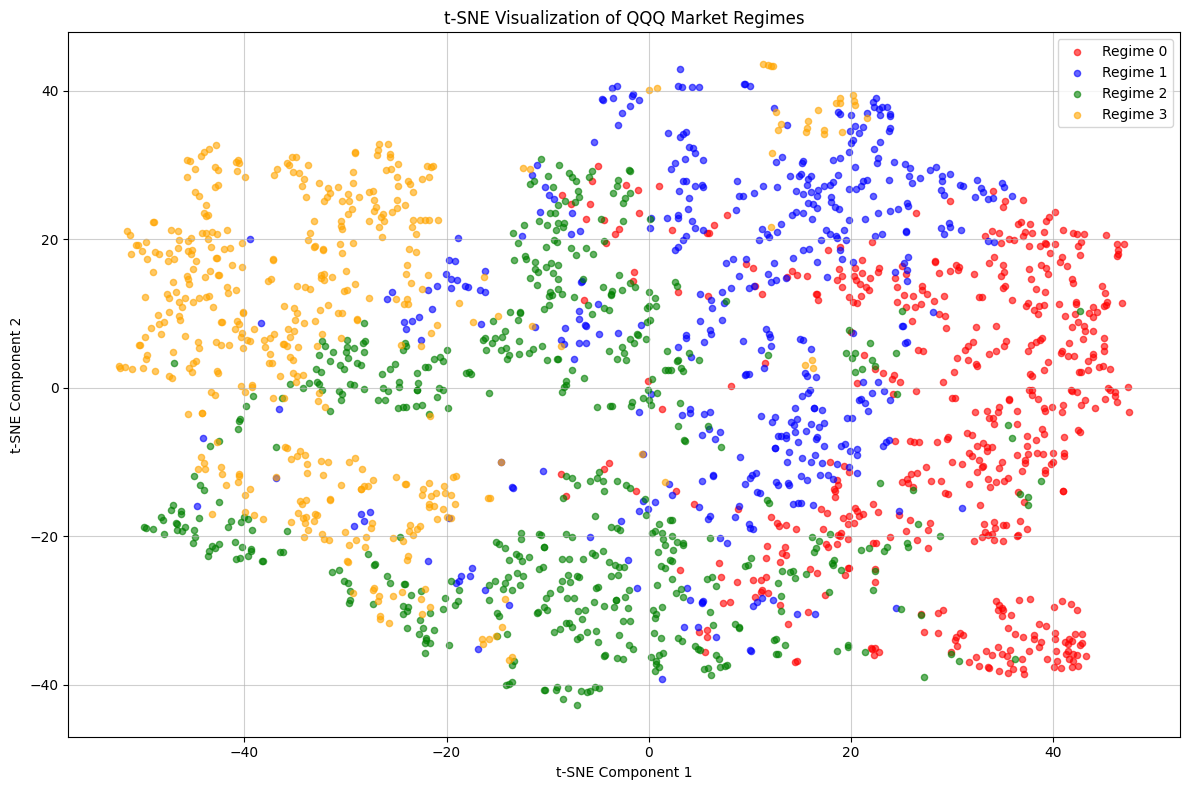

In [62]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Create the plot
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange']
regime_names = ['Regime 0', 'Regime 1', 'Regime 2', 'Regime 3']
for i in range(4):
    mask = qqq['regime'] == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                c=colors[i], label=regime_names[i], 
                alpha=0.6, s=20)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of QQQ Market Regimes')
plt.legend()
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()


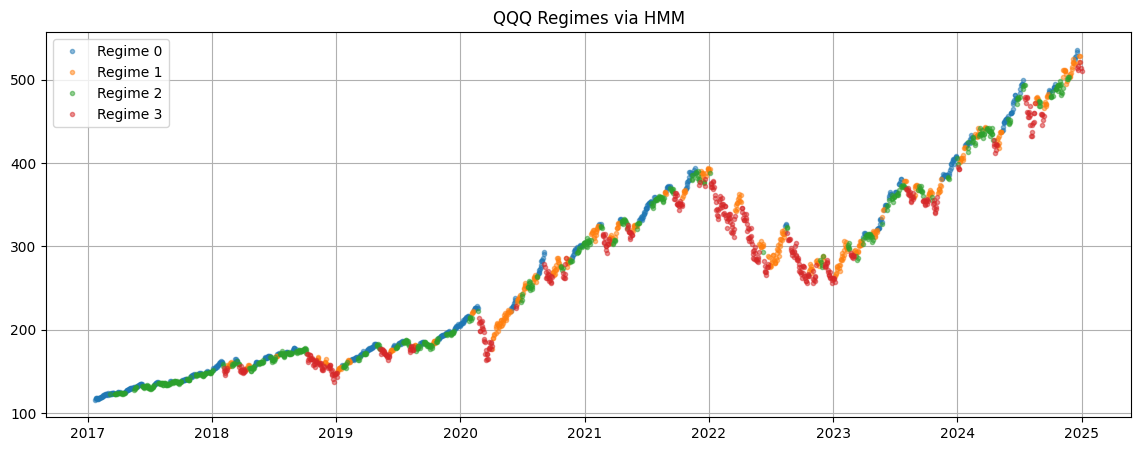

In [63]:
#Visualize
plt.figure(figsize=(14, 5))
for regime in sorted(qqq['regime'].unique()):
    mask = qqq['regime'] == regime
    plt.plot(qqq.index[mask], qqq['close'][mask], '.', label=f'Regime {regime}', alpha=0.5)
plt.title("QQQ Regimes via HMM")
plt.legend()
plt.grid()
plt.show()

In [64]:
joblib.dump(model, "hmm_model.pkl")

# Upload to QuantConnect ObjectStore
qb.ObjectStore.Save("hmm_model", "hmm_model.pkl")
print(qb.ObjectStore.ContainsKey("hmm_model"))  # should return True

import joblib
import os
from io import BytesIO

filename = 'hmm_model.pkl'
filename2 = 'hmm_scaler.pkl'
joblib.dump(model, filename)
joblib.dump(scaler, filename2)
assert os.path.exists(filename)
assert os.path.exists(filename2)

# Upload using save_bytes (robust, works around .save bug)
with open(filename, 'rb') as f:
    model_bytes = f.read()
with open(filename2, 'rb') as f:
    scaler_bytes = f.read()
qb.object_store.save_bytes('hmm_model', list(model_bytes))
qb.object_store.save_bytes('hmm_scaler', list(scaler_bytes))

# Verify upload by reading it back
def get_objstore_bytes(key):
    b = qb.object_store.read_bytes(key)
    if type(b).__name__ == 'Byte[]' or type(b).__name__.lower() == 'system.byte[]':
        b = bytes([int(x) for x in b])
    if isinstance(b, list):
        b = bytes(b)
    return b

store_bytes = get_objstore_bytes('hmm_model')
store_bytes2 = get_objstore_bytes('hmm_scaler')

# Round-trip load
_loaded_model = joblib.load(BytesIO(store_bytes))
_loaded_model2 = joblib.load(BytesIO(store_bytes2))
print('Model successfully round-tripped from ObjectStore with correct bytes.')

True
Model successfully round-tripped from ObjectStore with correct bytes.
